In [10]:
import pandas as pd
import numpy as np
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

- site_i – это индексы посещенных сайтов (текстовая расшифровка в pickle-файле site_dic.pkl)
- time_j – время посещения сайтов site_j
- target – целевая переменная, факт того что именно Иван ходил по всем этим сайтам)

Задача – Нагенерировать признаки, сделать их визуализацию и попробовать построить модель для определения Ивана(Это не главная задача, главное-признаки). По возможности обосновать выбор той или иной модели и метрики качества.

# Загрузка данных и их предобработка

In [14]:
# Данные по расшифровке индексов сайтов
dic = pd.DataFrame.from_dict(pd.read_pickle('site_dic.pkl'), orient='index').reset_index()
dic.columns = ['adress', 'index']
dic['domain'] = dic['adress'].apply(lambda x: re.findall('.\w+$', x)[0])

adresses = dict(zip(dic['index'], dic['adress']))

In [11]:
# Основные данные
train = pd.read_csv('train_sessions.csv')

In [17]:
time_cols = [i for i in train.columns if re.findall('time', i)]
for col in time_cols:
    train[col] = pd.to_datetime(train[col])
    
# Извлечение информации о дне недели и часе зхода на сайт
def hour(x):
    try:
        return int(re.findall('^\d\d', str(x))[0])
    except:
        return np.nan


for i in range(1, 11):
    train['wd'+str(i)] = train['time'+str(i)].dt.weekday
    train['h'+str(i)] = train['time'+str(i)].dt.time.apply(hour)

# Оценка дельты времени перехода с сайта на сайтв рамках одной сессии
for i in range(1, 10):
    train['delta'+str(i)] = (train['time'+str(i+1)] - train['time'+str(i)]).dt.seconds
    
train['delta_mean'] = train[[i for i in train.columns if re.findall('delta', i)]].mean(axis=1).fillna(0)
train['delta_max'] =  train[[i for i in train.columns if re.findall('delta', i)]].max(axis=1).fillna(0)

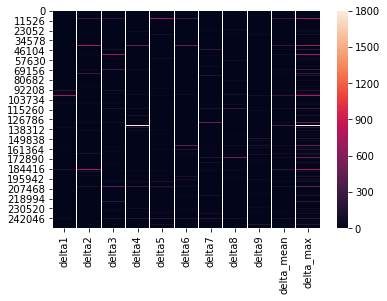

In [18]:
# Визуализация дельты времени перехода с сайта на сайтв рамках одной сессии
sns.heatmap(train[[i for i in train.columns if re.findall('delta', i)]])

In [19]:
print('Проверка длительности сессии')
print('Количество дней', train[[i for i in train.columns if re.findall('wd', i)]].T.nunique().T.unique())
print('Количество часов', train[[i for i in train.columns if re.findall('h', i)]].T.nunique().T.unique())

Проверка длительности сессии
Количество дней [1]
Количество часов [1 2]


-поскольку длительность сессии в рамках одного дня и одного-двух часов, то можем использовать только колонки wd1 и h1.

In [21]:
# Вытащим домен как косвенных идентификатор страны и языка пользователя
df_s = train[[i for i in train.columns if re.findall('site', i)]]
domains = dict(zip(dic['index'], dic['domain']))

for i in df_s.columns:
    df_s[i] = df_s[i].map(domains)
    
def unique_domain(a):
    return sorted(list(set([i for i in a if str(i)!='nan'])))


train['domains'] = list(map(unique_domain, df_s.values))

C:\Users\stepanovaev9\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [22]:
domains_df = pd.DataFrame()
for i in range(train['domains'].apply(len).max()):
    domains_df = pd.concat([domains_df, pd.get_dummies(train['domains'].str[i])], axis=1)
print(len(domains_df.columns))

523


In [23]:
for i in set(domains_df.columns[domains_df.columns.duplicated()]):
    domains_df['temp'] = domains_df[i].max(axis=1)
    domains_df.drop(i, axis=1, inplace=True)
    domains_df[i] = domains_df['temp'].copy()
print(len(domains_df.columns))

221


In [35]:
# Оценочный расчет длительности сессии
time_df = train[[i for i in train.columns if re.findall('time', i)]]
train['session_duration'] = (time_df.max(axis=1) - time_df.min(axis=1)).dt.seconds

In [36]:
# Собираем основные данные в единый датафрейм
final_train = domains_df.join(train[['wd1', 'h1', 'session_duration', 'delta_mean', 'delta_max', 'target']])

Text(0.5, 1.0, 'Рейтинг популярности доментов')

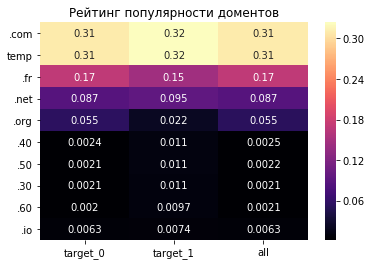

In [37]:
# Визуализация попудярности доментов
percentage = pd.concat([(final_train[final_train['target']==0][domains_df.columns].sum() / final_train[final_train['target']==0][domains_df.columns].sum().sum()),
                        (final_train[final_train['target']==1][domains_df.columns].sum() / final_train[final_train['target']==1][domains_df.columns].sum().sum()),
                       (final_train[domains_df.columns].sum() / final_train[domains_df.columns].sum().sum())],
                       axis=1).sort_values(1, ascending=False)
percentage.columns = ['target_0', 'target_1', 'all']

sns.heatmap(percentage.head(10), annot=True, cmap='magma')
plt.title('Рейтинг популярности доментов')

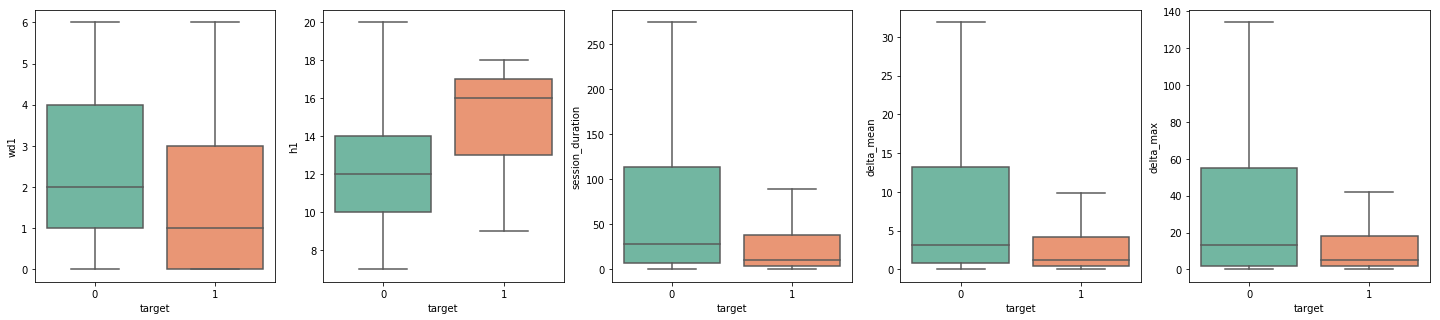

In [38]:
# Визуализация соотношений выбранный фич в разрезе классов
features = ['wd1', 'h1', 'session_duration', 'delta_mean', 'delta_max']

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,5))
d = dict(zip(features, [ax1, ax2, ax3, ax4, ax5]))
for i in features:
    sns.boxplot(x='target', y=i, data=final_train, palette='Set2', ax=d[i], showfliers=False)

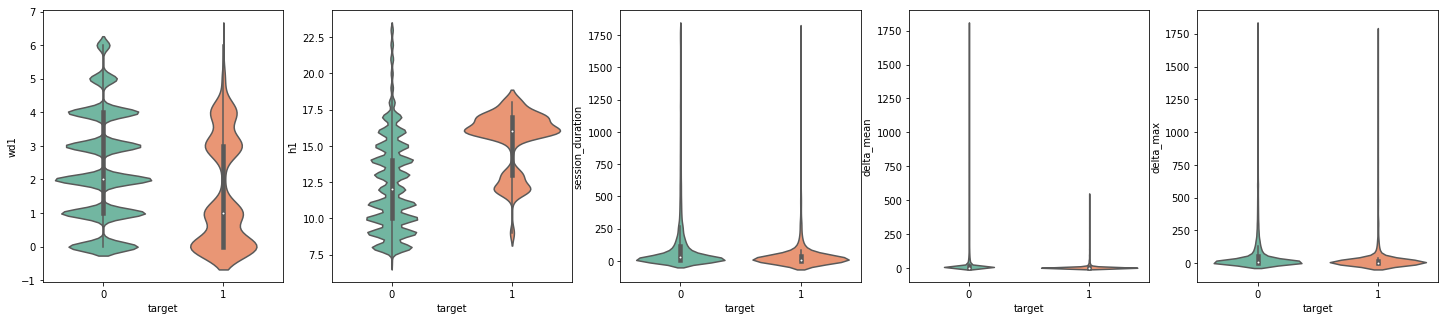

In [39]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,5))
d = dict(zip(features, [ax1, ax2, ax3, ax4, ax5]))
for i in features:
    sns.violinplot(x='target', y=i, data=final_train, palette='Set2', ax=d[i])

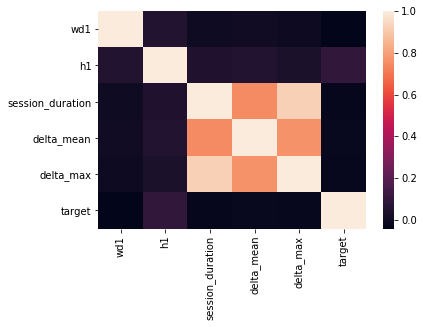

In [40]:
# Оценка корреляции между выделенными признаками
corr_df = final_train[features+['target']].corr()
sns.heatmap(corr_df)

In [41]:
# Предобработка категориальных значений
temp = pd.get_dummies(final_train['wd1'])
temp.columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
final_train = pd.concat([final_train.drop('wd1', axis=1), temp], axis=1)

In [43]:
# Continuous data standardisation
final_train['h1'] = final_train['h1'] / 24

for i in ['session_duration', 'delta_mean', 'delta_max']:
    final_train[i] = final_train[i] / final_train[i].max()

# Построение моделей

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [57]:
cols = list(final_train.columns)
cols.remove('target')

X = final_train[cols]
y = final_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [58]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
pred_log_0 = logmodel.predict(X_test)
print(classification_report(y_test, pred_log_0))
print(confusion_matrix(y_test, pred_log_0))

C:\Users\stepanovaev9\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     82936
           1       1.00      0.01      0.02       740

   micro avg       0.99      0.99      0.99     83676
   macro avg       1.00      0.51      0.51     83676
weighted avg       0.99      0.99      0.99     83676

[[82936     0]
 [  732     8]]


In [60]:
gradboost_0 = GradientBoostingClassifier()
gradboost_0.fit(X_train , y_train)
pred_gb_0 = gradboost_0.predict(X_test)
print(classification_report(y_test, pred_gb_0))
print(confusion_matrix(y_test, pred_gb_0))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     82936
           1       0.78      0.04      0.08       740

   micro avg       0.99      0.99      0.99     83676
   macro avg       0.88      0.52      0.54     83676
weighted avg       0.99      0.99      0.99     83676

[[82927     9]
 [  709    31]]


In [70]:
print('Количество образцоа классов target=0 И target=1', list(train['target'].value_counts()))

Количество образцоа классов target=0 И target=1 [251264, 2297]


<br>Несбалансированность классов приводит к фатально низкому f1-score у класса target=1.
<br>Поэтому применимметод SMOTE (Synthetic Minority Over-sampling Technique) для балансировки классов.
<br>SMOTE генерирует новые образцы, когерентные распределению минорного класса.

In [47]:
from imblearn.over_sampling import SMOTE

In [69]:
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print('Распределение классов до применения SMOTE', list(y_train.value_counts()))
print('Распределение классов после применения SMOTE', np.bincount(y_train_res))

Распределение классов до применения SMOTE [168328, 1557]
Распределение классов после применения SMOTE [168328 168328]


Поскольку градиентный бустинг показал несколько лучший результат на тесте с несбалансированными классами, то будем его использовать, увеличив количество итераций в 10 раз (от стандартных 100 до 1000):

In [63]:
gradboost = GradientBoostingClassifier(n_estimators=1000)
gradboost.fit(X_train_res , y_train_res)
pred_gb = gradboost.predict(X_test)
print(classification_report(y_test, pred_gb))
print(confusion_matrix(y_test, pred_gb))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     82936
           1       0.13      0.73      0.21       740

   micro avg       0.95      0.95      0.95     83676
   macro avg       0.56      0.84      0.59     83676
weighted avg       0.99      0.95      0.97     83676

[[79180  3756]
 [  203   537]]


Точность просела, но полнота заметно выросла, что в итоге дает улучшенный f4-score = 0,21.

### Дополнительные возможности

Также можно оценить тематику сайтов из их названий и использовать
- популярную у всех или
- популярнкю у класса target=1
<br>тематики в качестве идентифицируещего класс признака.

In [65]:
from collections import Counter

def bag(raw):
    x = raw.values.tolist()
    x = pd.Series([inner for outer in x for inner in outer]).dropna()
    x = x.map(adresses).apply(lambda x: re.findall('\w+', x)).str[:-1].values.tolist() # without domain, because it was analysied separatly
    x = [inner for outer in x for inner in outer]
    return pd.DataFrame.from_dict(dict(Counter(x)), orient='index')

dx = bag(train[train['target']==1][df_s.columns]).rename(columns={0:'target_1'})
dy = bag(train[df_s.columns]).rename(columns={0:'all'})

In [66]:
bags = pd.concat([dx, dy], axis=1)
bags.fillna(0, inplace=True)

bags['target_1'] = bags['target_1'] / bags['target_1'].sum()
bags['all'] = bags['all'] / bags['all'].sum()
bags['ratio'] = bags['target_1'] / bags['all']

bags.reset_index(inplace=True)
data = bags[bags['index'].str.len()>=5].set_index('index')

C:\Users\stepanovaev9\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Рейтинг популярности сайтов сортировка по убывания популярности у всех')

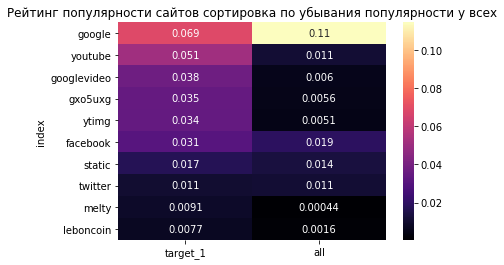

In [67]:
sns.heatmap(data.sort_values('target_1', ascending=False).head(10)[['target_1', 'all']], annot=True, cmap='magma')
plt.title('Рейтинг популярности сайтов сортировка по убывания популярности у всех')

Text(0.5, 1.0, 'Рейтинг популярности сайтов сортировка по убыванию соотношения популряности у target_1 к поулярности у всех')

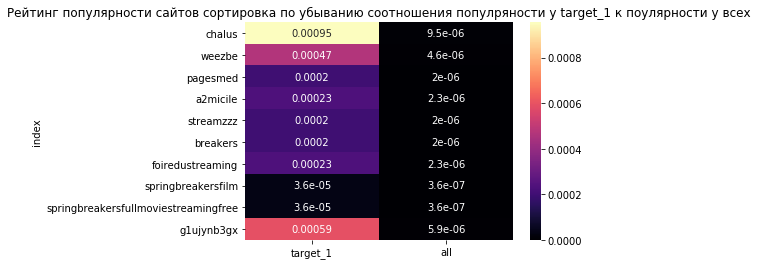

In [68]:
sns.heatmap(data.sort_values('ratio', ascending=False).head(10)[['target_1', 'all']], annot=True, cmap='magma')
plt.title('Рейтинг популярности сайтов сортировка по убыванию соотношения популряности у target_1 к поулярности у всех')